In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare

In [ ]:
# MNIST Dataset
transform = transforms.Compose([
      transforms.ToTensor(), 
      transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Define Generator and Discriminator
This part is refer and modified on Iyeoni's design idea. The hyperparameters are tried and modified in the later "Trainer part".

In [ ]:
class Generator(nn.Module):
    def __init__(self, bottleneck, g_input_dim=100, g_output_dim=28*28):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, bottleneck)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, bottleneck, d_input_dim=28*28):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, bottleneck)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# Define a Trainer

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class Trainer:
    def __init__(self, D, G, z_dim=100):
        self.D = D
        self.G = G
        self.criterion = nn.BCELoss() 
        self.z_dim = z_dim
        self.D_losses = list()
        self.G_losses = list()

    def fit(self, dataset, n_epoch=100, batch_size=64, lr=1e-5):
        self.batch_size = batch_size
        self.D = self.D.to(device)
        self.G = self.G.to(device)
        # optimizer
        self.D_optimizer = optim.Adam(self.D.parameters(), lr = lr)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr = lr)
        # data loader
        data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
        N = len(data_loader)
        for epoch in tqdm(range(1, n_epoch+1)):
            D_loss, G_loss = 0, 0
            for x, _ in data_loader:
                if x.shape[0] != self.batch_size:
                    break
                D_loss += self.D_train(x)
                G_loss += self.G_train(x)
            D_loss = D_loss/N
            G_loss = G_loss/N
            self.D_losses.append(D_loss)
            self.G_losses.append(G_loss)
            print(f'[{epoch}/{n_epoch}] D_loss: {D_loss:.4f}, G_loss; {G_loss: .4f}')
            if epoch%50 == 0:
                # with torch.no_grad():
                #     test_z = Variable(torch.randn(n, self.z_dim).to(device))
                #     generated = self.G(test_z)
                #     generated = generated.view(generated.size(0), 1, 28, 28).cpu()
                #     for i in range(len(ax)):
                #         img = torch.squeeze(generated[i])
                #         ax[i].imshow(img)
                fig, ax = plt.subplots(1,3, figsize=(20,20))
                self.visualize_result(3, title='', ax=ax)



    def D_train(self, x, mnist_dim=28*28):
        #Train the discriminator
        D.zero_grad()

        # train discriminator on real
        x_real, y_real = x.view(-1, mnist_dim), torch.ones(self.batch_size, 1)            
        # send to device
        x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

        D_output = D(x_real)
        D_real_loss = self.criterion(D_output, y_real)
        D_real_score = D_output

        # train discriminator on facke
        z = Variable(torch.randn(self.batch_size, self.z_dim).to(device))
        x_fake, y_fake = self.G(z), Variable(torch.zeros(self.batch_size, 1).to(device))

        D_output = self.D(x_fake)
        D_fake_loss = self.criterion(D_output, y_fake)
        D_fake_score = D_output

        # gradient backprop & optimize ONLY D's parameters
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        self.D_optimizer.step()
            
        return  D_loss.data.item()

    def G_train(self, x):
        #Train the generator
        G.zero_grad()

        z = Variable(torch.randn(self.batch_size, self.z_dim).to(device))
        y = Variable(torch.ones(self.batch_size, 1).to(device))

        G_output = self.G(z)
        D_output = self.D(G_output)
        G_loss = self.criterion(D_output, y)

        # gradient backprop & optimize ONLY G's parameters
        G_loss.backward()
        self.G_optimizer.step()
        
        return G_loss.data.item()

    def plot_learning_curve(self, ax=None, title=''):
        ax.plot(self.D_losses, '-', label = 'Discriminator loss')
        ax.plot(self.G_losses, '-', label = 'Generator loss')

        ax.legend()
        ax.grid()
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Losses')
        ax.set_title(title)

    def visualize_result(self, n, ax=None, title=''):
        with torch.no_grad():
            test_z = Variable(torch.randn(n, self.z_dim).to(device))
            generated = self.G(test_z)
            generated = generated.view(generated.size(0), 1, 28, 28).cpu()
            for i in range(len(ax)):
                img = torch.squeeze(generated[i])
                ax[i].imshow(img)

# Search optimal hyperparameters

## learning rate


Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


[1/200] D_loss: 0.2706, G_loss;  6.6929
[2/200] D_loss: 0.0007, G_loss;  13.8928
[3/200] D_loss: 0.0060, G_loss;  12.4332
[4/200] D_loss: 0.0001, G_loss;  14.5871
[5/200] D_loss: 0.0001, G_loss;  16.5531
[6/200] D_loss: 0.0000, G_loss;  18.7645
[7/200] D_loss: 0.0000, G_loss;  20.6824
[8/200] D_loss: 0.0000, G_loss;  21.8571
[9/200] D_loss: 0.0000, G_loss;  22.7942
[10/200] D_loss: 0.0000, G_loss;  25.1167
[11/200] D_loss: 0.0000, G_loss;  27.0597
[12/200] D_loss: 0.0008, G_loss;  30.2268
[13/200] D_loss: 0.0000, G_loss;  29.7500
[14/200] D_loss: 0.0000, G_loss;  29.2621
[15/200] D_loss: 0.0000, G_loss;  29.2780
[16/200] D_loss: 0.0000, G_loss;  28.4003
[17/200] D_loss: 0.0000, G_loss;  28.8068
[18/200] D_loss: 0.0000, G_loss;  29.3629
[19/200] D_loss: 0.0143, G_loss;  23.2955
[20/200] D_loss: 0.0000, G_loss;  26.3348
[21/200] D_loss: 0.0000, G_loss;  28.0166
[22/200] D_loss: 0.0000, G_loss;  32.2416
[23/200] D_loss: 0.0000, G_loss;  32.9851
[24/200] D_loss: 0.0000, G_loss;  33.4629
[2

[1/200] D_loss: 1.1742, G_loss;  0.9252
[2/200] D_loss: 1.2470, G_loss;  0.9020
[3/200] D_loss: 1.1315, G_loss;  1.0481
[4/200] D_loss: 0.9116, G_loss;  1.4902
[5/200] D_loss: 0.8278, G_loss;  1.7096
[6/200] D_loss: 0.9084, G_loss;  1.5674
[7/200] D_loss: 0.9992, G_loss;  1.3538
[8/200] D_loss: 1.0834, G_loss;  1.2061
[9/200] D_loss: 1.1128, G_loss;  1.1224
[10/200] D_loss: 1.1529, G_loss;  1.0437
[11/200] D_loss: 1.1756, G_loss;  1.0160
[12/200] D_loss: 1.1233, G_loss;  1.0863
[13/200] D_loss: 1.1427, G_loss;  1.0564
[14/200] D_loss: 1.1773, G_loss;  1.0007
[15/200] D_loss: 1.1497, G_loss;  1.0241
[16/200] D_loss: 1.2035, G_loss;  0.9659
[17/200] D_loss: 1.2358, G_loss;  0.9190
[18/200] D_loss: 1.2419, G_loss;  0.9102
[19/200] D_loss: 1.2481, G_loss;  0.9076
[20/200] D_loss: 1.2568, G_loss;  0.8763
[21/200] D_loss: 1.2524, G_loss;  0.8911
[22/200] D_loss: 1.2341, G_loss;  0.9067
[23/200] D_loss: 1.2669, G_loss;  0.8640
[24/200] D_loss: 1.2199, G_loss;  0.9228
[25/200] D_loss: 1.2453, 

[1/200] D_loss: 1.2668, G_loss;  0.6702
[2/200] D_loss: 1.3044, G_loss;  0.6965
[3/200] D_loss: 1.2606, G_loss;  0.7204
[4/200] D_loss: 1.1086, G_loss;  0.8055
[5/200] D_loss: 1.0079, G_loss;  0.9803
[6/200] D_loss: 0.8280, G_loss;  1.2561
[7/200] D_loss: 0.6428, G_loss;  1.5938
[8/200] D_loss: 0.4605, G_loss;  2.0182
[9/200] D_loss: 0.3525, G_loss;  2.5158
[10/200] D_loss: 0.3207, G_loss;  2.8980
[11/200] D_loss: 0.2434, G_loss;  3.4932
[12/200] D_loss: 0.1836, G_loss;  3.7438
[13/200] D_loss: 0.2604, G_loss;  3.5949
[14/200] D_loss: 0.2136, G_loss;  3.8185
[15/200] D_loss: 0.1859, G_loss;  4.1964
[16/200] D_loss: 0.1574, G_loss;  4.4686
[17/200] D_loss: 0.1499, G_loss;  4.8007
[18/200] D_loss: 0.1760, G_loss;  4.9646
[19/200] D_loss: 0.1559, G_loss;  4.4225
[20/200] D_loss: 0.1489, G_loss;  4.6934
[21/200] D_loss: 0.1548, G_loss;  4.9028
[22/200] D_loss: 0.1597, G_loss;  4.4012
[23/200] D_loss: 0.1679, G_loss;  4.7094
[24/200] D_loss: 0.1540, G_loss;  4.9291
[25/200] D_loss: 0.1715, 

[1/200] D_loss: 1.3104, G_loss;  0.6231
[2/200] D_loss: 1.3110, G_loss;  0.6959
[3/200] D_loss: 1.1813, G_loss;  0.7380
[4/200] D_loss: 1.2296, G_loss;  0.7068
[5/200] D_loss: 1.2693, G_loss;  0.7085
[6/200] D_loss: 1.1662, G_loss;  0.7727
[7/200] D_loss: 1.1020, G_loss;  0.8234
[8/200] D_loss: 1.0392, G_loss;  0.8981
[9/200] D_loss: 0.8383, G_loss;  1.0900
[10/200] D_loss: 0.7873, G_loss;  1.2311
[11/200] D_loss: 0.6944, G_loss;  1.4130
[12/200] D_loss: 0.5828, G_loss;  1.6116
[13/200] D_loss: 0.4446, G_loss;  2.0417
[14/200] D_loss: 0.3706, G_loss;  2.1869
[15/200] D_loss: 0.4104, G_loss;  2.2737
[16/200] D_loss: 0.2844, G_loss;  2.8015
[17/200] D_loss: 0.2000, G_loss;  3.2424
[18/200] D_loss: 0.3063, G_loss;  3.1465
[19/200] D_loss: 0.1813, G_loss;  3.5805
[20/200] D_loss: 0.1872, G_loss;  3.5513
[21/200] D_loss: 0.1301, G_loss;  4.2027
[22/200] D_loss: 0.1170, G_loss;  4.8892
[23/200] D_loss: 0.1421, G_loss;  4.6018
[24/200] D_loss: 0.1326, G_loss;  4.4647
[25/200] D_loss: 0.1112, 

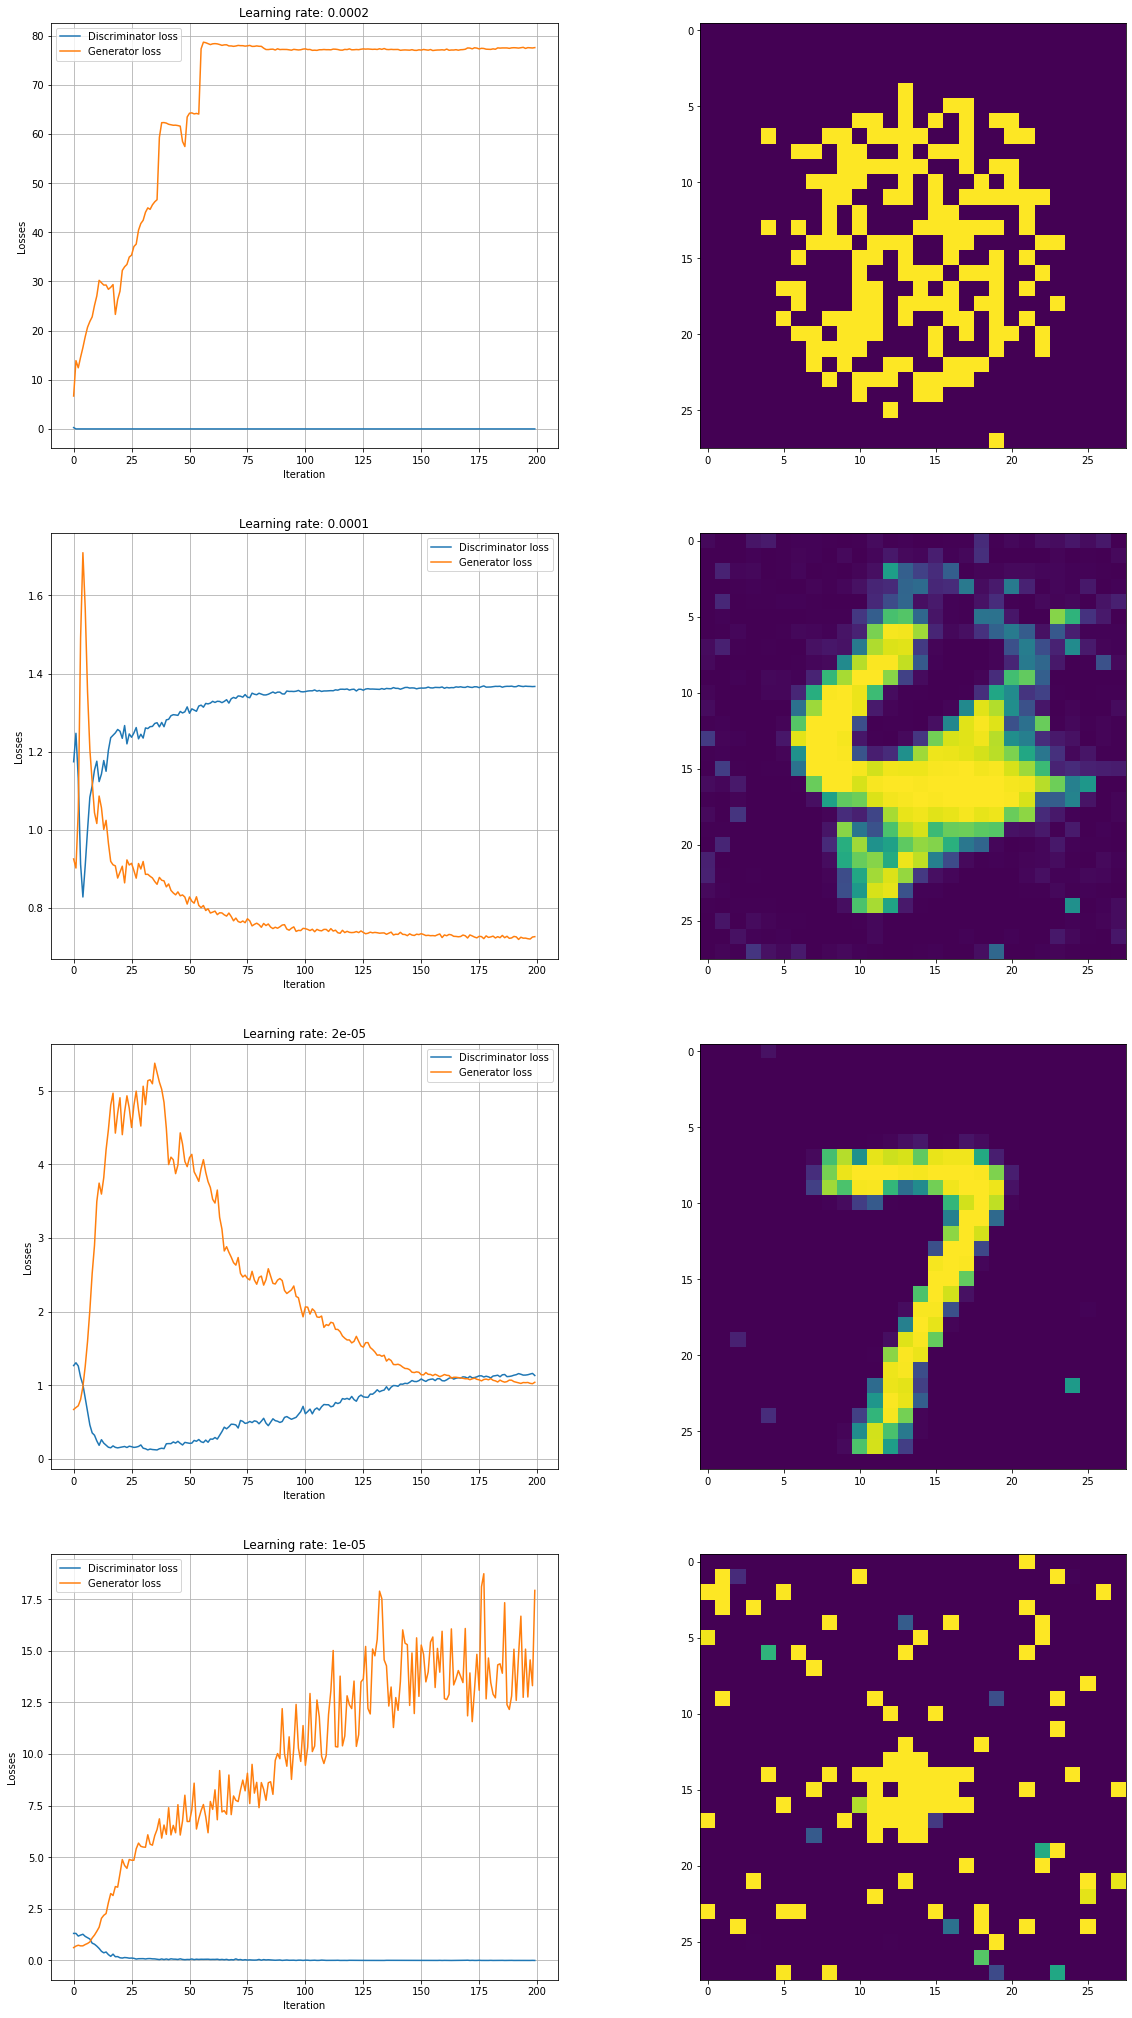

In [ ]:
Z_DIM = 100
learning_rates = [2e-4, 1e-4, 2e-5, 1e-5]#5e-4]#, 1e-4, 5e-5, 1e-5]
EPOCH = 200
BOTTLENECK = 256

trials = len(learning_rates)



fig, axes = plt.subplots(trials, 2, figsize=(20, 9*trials))
for i in range(trials):
    G = Generator(BOTTLENECK, g_input_dim=Z_DIM)
    print(G)
    D = Discriminator(BOTTLENECK)
    print(D)
    model = Trainer(D, G, z_dim=Z_DIM)
    model.fit(train_dataset, n_epoch=EPOCH, lr=learning_rates[i], batch_size=64)
    model.plot_learning_curve(title=f'Learning rate: {learning_rates[i]}', ax=axes[i][0])
    model.visualize_result(5, title=f'Bottleneck: {learning_rates[i]}', ax=axes[i][1:])

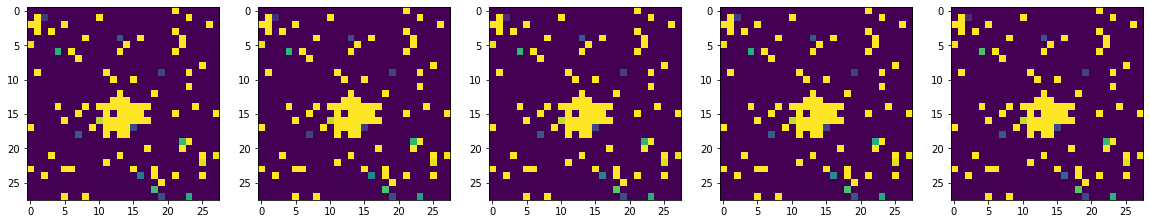

In [ ]:
# model = Trainer(D, G, z_dim=Z_DIM)
# fig, ax = plt.subplots(1,5, figsize=(20,20))
# model.visualize_result(5, title='', ax=ax)

## \# of Epoch
Every 50 epoch, 3 digits image are generated to see the result


Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


[1/200] D_loss: 1.2730, G_loss;  0.6238
[2/200] D_loss: 1.3305, G_loss;  0.6571
[3/200] D_loss: 1.2757, G_loss;  0.6840
[4/200] D_loss: 1.1947, G_loss;  0.7838
[5/200] D_loss: 0.9848, G_loss;  0.9295
[6/200] D_loss: 0.7979, G_loss;  1.2274
[7/200] D_loss: 0.6161, G_loss;  1.6955
[8/200] D_loss: 0.3687, G_loss;  2.2802
[9/200] D_loss: 0.3200, G_loss;  2.6871
[10/200] D_loss: 0.2550, G_loss;  3.1802
[11/200] D_loss: 0.2242, G_loss;  3.4403
[12/200] D_loss: 0.1457, G_loss;  4.2275
[13/200] D_loss: 0.1293, G_loss;  4.3789
[14/200] D_loss: 0.1972, G_loss;  3.9883
[15/200] D_loss: 0.1380, G_loss;  4.3989
[16/200] D_loss: 0.1283, G_loss;  4.8200
[17/200] D_loss: 0.1640, G_loss;  4.4841
[18/200] D_loss: 0.1360, G_loss;  4.7627
[19/200] D_loss: 0.1429, G_loss;  5.1204
[20/200] D_loss: 0.1445, G_loss;  4.7537
[21/200] D_loss: 0.1239, G_loss;  4.9611
[22/200] D_loss: 0.1221, G_loss;  5.0541
[23/200] D_loss: 0.1003, G_loss;  5.4532
[24/200] D_loss: 0.1044, G_loss;  5.3747
[25/200] D_loss: 0.1129, 

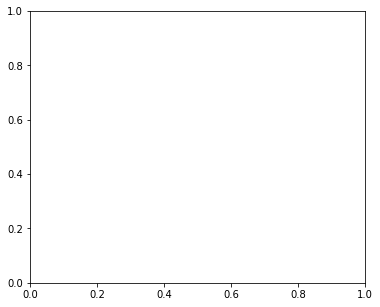

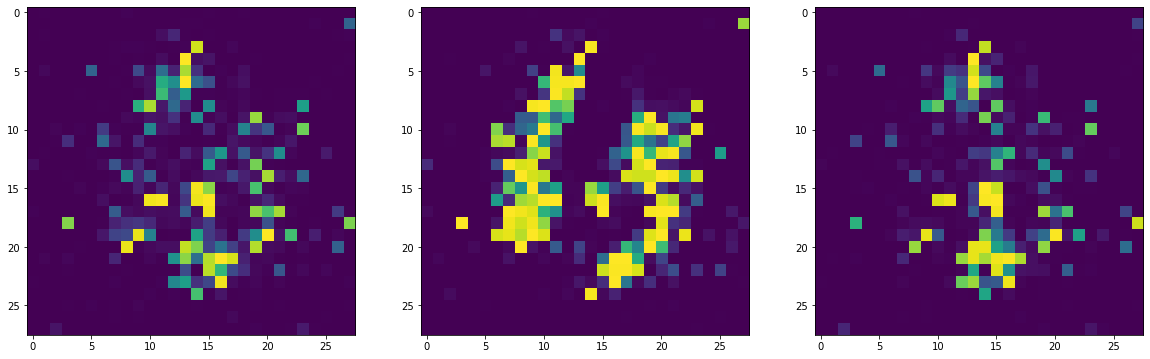

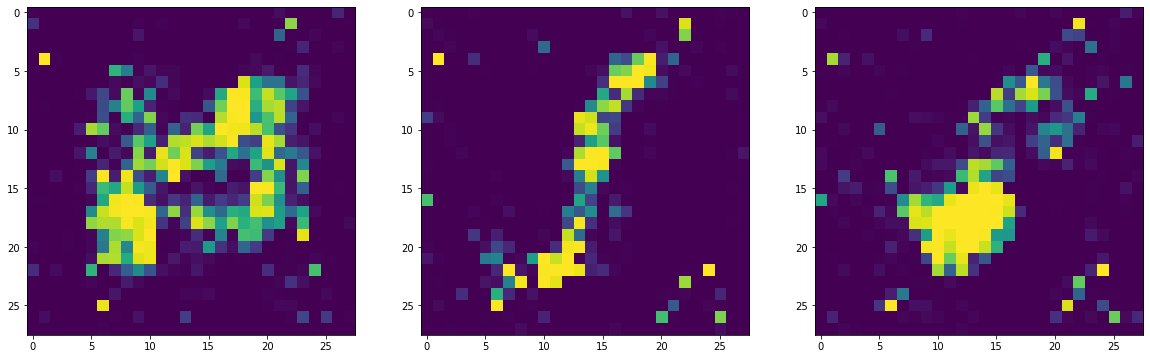

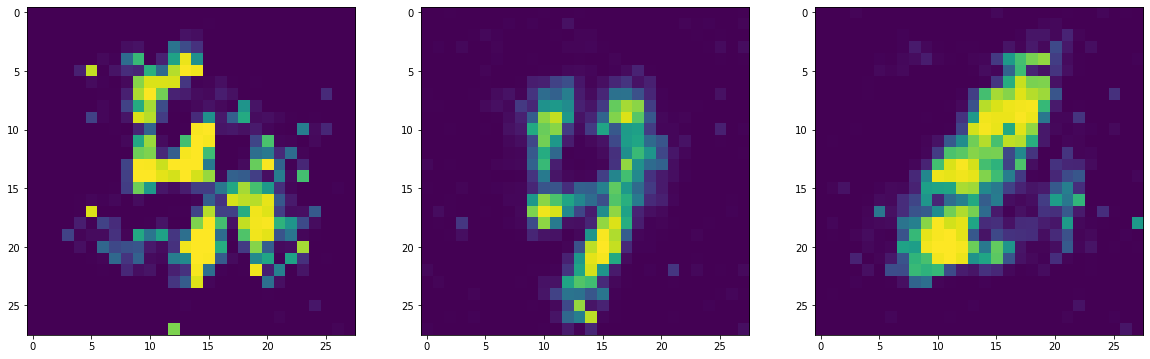

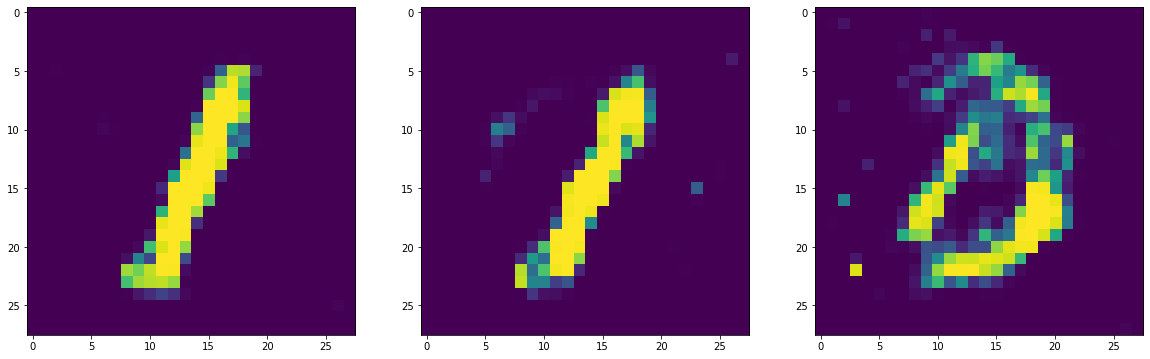

In [ ]:
Z_DIM = 100
learning_rate = 2e-5
epochs = [200]
BOTTLENECK = 256

trials = len(epochs)
fig, axes = plt.subplots(trials, 1, figsize=(6, 5*trials))
for i in range(trials):
    G = Generator(BOTTLENECK, g_input_dim=Z_DIM)
    print(G)
    D = Discriminator(BOTTLENECK)
    print(D)
    model = Trainer(D, G, z_dim=Z_DIM)
    model.fit(train_dataset, n_epoch=epochs[i], lr=learning_rate, batch_size=64)
    # model.plot_learning_curve(title=f'Epoch: {epochs[i]}', ax=axes[i])
    # model.visualize_result(5, title=f'Bottleneck: {learning_rates[i]}', ax=axes[i][1:])

Generated the test result after the GAN is trained

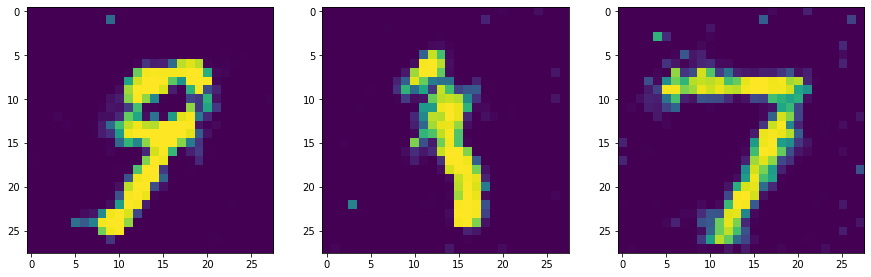

In [ ]:
model = Trainer(D, G, z_dim=Z_DIM)
fig, ax = plt.subplots(1,3, figsize=(15,15))
model.visualize_result(3, title='', ax=ax)

Generate the output image for 64

In [ ]:
#generated the output result
with torch.no_grad():
    test_z = Variable(torch.randn(64, Z_DIM).to(device))
    generated = G(test_z)
    # img = generated.size(0), 1, 28, 28)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')

## Bottleneck of generator & discriminator layers


In [ ]:
Z_DIM = 100
learning_rate = 5e-4
epochs = 200
bottlenecks = [32, 64, 128, 256]

trials = len(bottlenecks)
fig, axes = plt.subplots(trials, 1, figsize=(6, 5*trials))
for i in range(trials):
    G = Generator(bottlenecks[i], g_input_dim=Z_DIM)
    print(G)
    D = Discriminator(bottlenecks[i])
    print(D)
    model = Trainer(D, G, z_dim=Z_DIM)
    model.fit(train_dataset, n_epoch=epochs, lr=learning_rates, batch_size=64)
    model.visualize_result(5, title=f'Bottleneck: {bottlenecks[i]}', ax=axes[i])